***Penguin: Part 2 / 2***

This file focus on building decision trees and testing them using the subsets from the previous part

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import graphviz # this module is not installed natively in anaconda environment, might need some setup beforehand
from IPython.display import Image
import time

In [2]:
#2.1 is in the other notebook

#2.2
def train(feature, label):
    dt = DecisionTreeClassifier(criterion="entropy", random_state=273) # set random_state a static number for cosistent results between runs with the same input
    dt.fit(feature, label)
    return dt

#2.2
def visualize_tree(model, feature_names, class_names, filename="decision_tree"):
    # Export as DOT data
    dot_data = export_graphviz(
        model,
        out_file=None,
        feature_names=feature_names,
        class_names=class_names,
        filled=True,
        rounded=True,
        special_characters=True
    )
    
    # Render to PDF and display
    graph = graphviz.Source(dot_data)
    graph.render(filename, format='pdf', cleanup=True)  # Saves as 'filename.pdf'
    return graph  # Optionally return the graph object for in-notebook rendering

#2.3
def predict_and_test(feature, label, tree, accuracies, weighted_f1s):
    label_pred = tree.predict(feature)
    print("\nClassification Report:")
    report = classification_report(label, label_pred, output_dict=True)
    # save these two values for futher analysis
    accuracies.append(report["accuracy"])
    weighted_f1s.append(report["weighted avg"]["f1-score"])
    print(classification_report(label, label_pred))
    
    visualize_confusion_matrix(label, label_pred, dt.classes_)

def visualize_confusion_matrix(label, label_pred, class_labels, title="Confusion Matrix"):
    # Generate confusion matrix
    cm = confusion_matrix(label, label_pred, labels=class_labels)

    # Display
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(cmap="Blues", values_format='d')  # 'd' = integer formatting

    plt.title(title)
    plt.grid(False)
    plt.tight_layout()
    plt.show()



decision tree (40_60)
train time: 0.0036187171936035156s


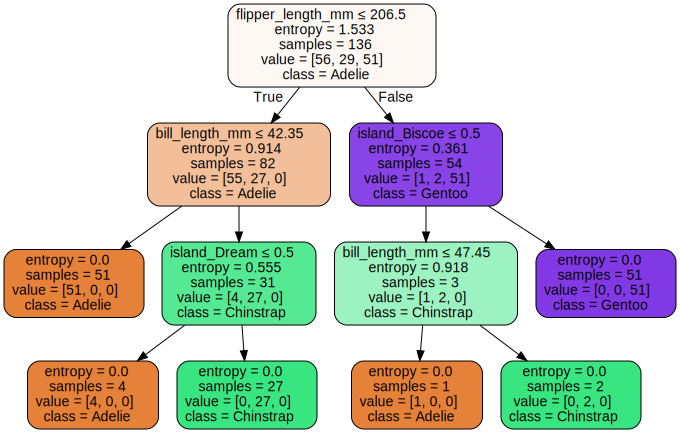


Classification Report:
              precision    recall  f1-score   support

      Adelie       0.98      0.98      0.98        95
   Chinstrap       0.95      0.97      0.96        39
      Gentoo       1.00      0.99      0.99        72

    accuracy                           0.98       206
   macro avg       0.98      0.98      0.98       206
weighted avg       0.98      0.98      0.98       206



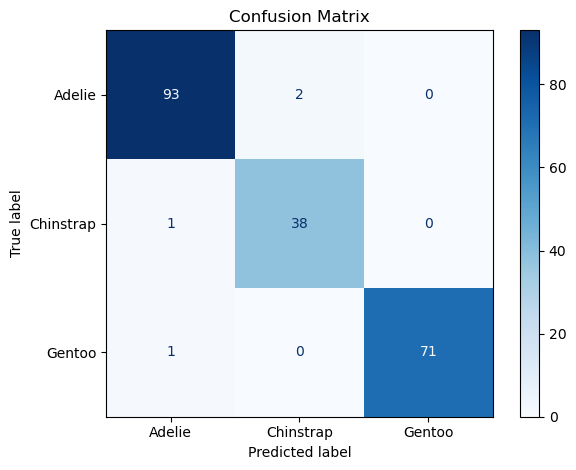


decision tree (60_40)
train time: 0.003326416015625s


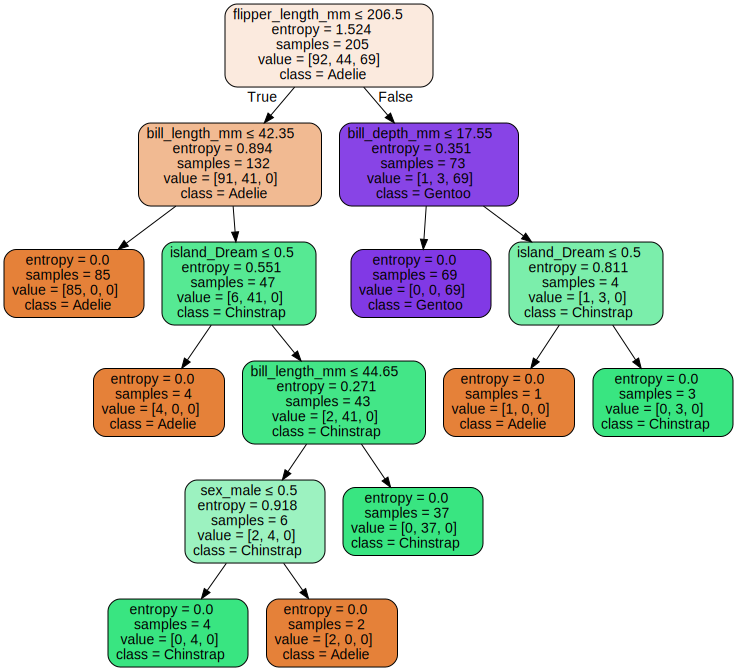


Classification Report:
              precision    recall  f1-score   support

      Adelie       0.97      0.98      0.97        59
   Chinstrap       0.96      0.96      0.96        24
      Gentoo       1.00      0.98      0.99        54

    accuracy                           0.98       137
   macro avg       0.97      0.97      0.97       137
weighted avg       0.98      0.98      0.98       137



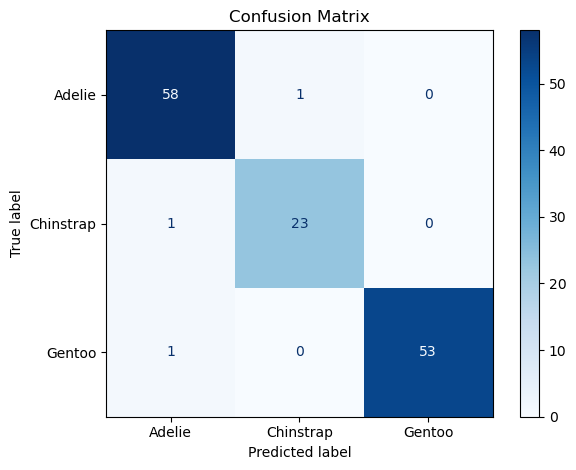


decision tree (80_20)
train time: 0.0031278133392333984s


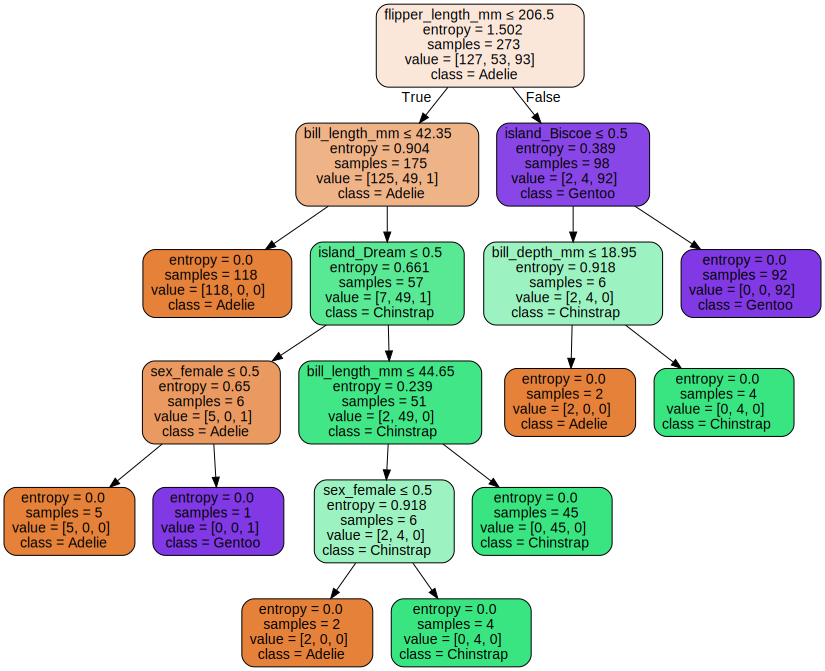


Classification Report:
              precision    recall  f1-score   support

      Adelie       0.96      1.00      0.98        24
   Chinstrap       1.00      0.93      0.97        15
      Gentoo       1.00      1.00      1.00        30

    accuracy                           0.99        69
   macro avg       0.99      0.98      0.98        69
weighted avg       0.99      0.99      0.99        69



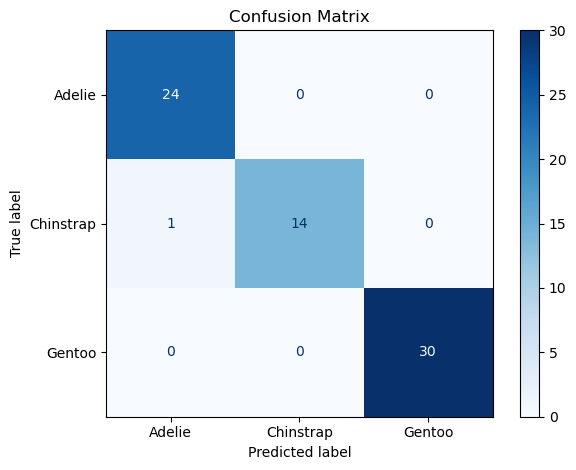


decision tree (90_10)
train time: 0.004205942153930664s


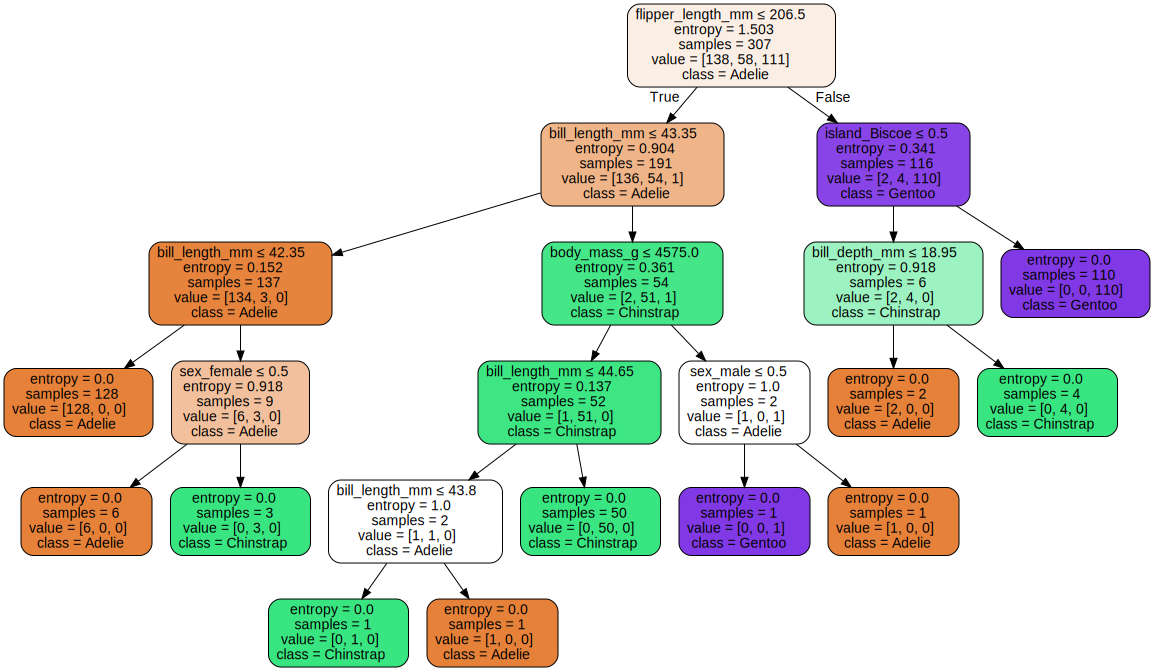


Classification Report:
              precision    recall  f1-score   support

      Adelie       0.92      0.85      0.88        13
   Chinstrap       0.82      0.90      0.86        10
      Gentoo       1.00      1.00      1.00        12

    accuracy                           0.91        35
   macro avg       0.91      0.92      0.91        35
weighted avg       0.92      0.91      0.91        35



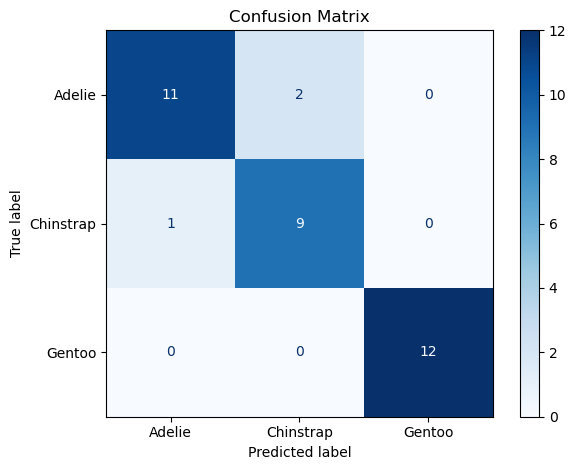

In [3]:
test_sizes = [0.6, 0.4, 0.2, 0.1]

df = pd.read_csv('clean_data/cleaned_penguins_dataset.csv')
island_cols = [col for col in df.columns if col.startswith("island_")]
sex_cols = [col for col in df.columns if col.startswith("sex_")]
feature_cols = ["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g", "year"] + island_cols + sex_cols

accuracy_scores = []
weighted_f1_scores = []
train_times = []
labels = []

for size in test_sizes:
    test_pct = int(size * 100)
    train_pct = 100 - test_pct
    postfix = f"{train_pct}_{test_pct}"
    labels.append(postfix)

    feature_train = pd.read_csv(f'penguin_prepared_subsets/feature_train_{postfix}.csv')
    feature_test = pd.read_csv(f'penguin_prepared_subsets/feature_test_{postfix}.csv')
    label_train = pd.read_csv(f'penguin_prepared_subsets/label_train_{postfix}.csv')
    label_test = pd.read_csv(f'penguin_prepared_subsets/label_test_{postfix}.csv')

    start_time = time.time()
    dt = train(feature_train, label_train)
    train_time = time.time() - start_time
    train_times.append(train_time)
    
    tree = visualize_tree(dt, feature_cols, dt.classes_, f'id3_tree/penguin_decision_tree_{postfix}')
    print('')
    print(f'decision tree ({postfix})')
    print(f'train time: {train_time}s')
    display(tree)
    
    predict_and_test(feature_test, label_test, dt, accuracy_scores, weighted_f1_scores)



Across all trained decision trees, flipper length and bill length consistently emerge as the most discriminative features for classifying penguin species. These attributes typically appear near the root of the tree, indicating their high information gain and strong influence on the model's decision boundaries.

In contrast, features such as bill depth and body mass contribute less to the model’s predictive power. They tend to appear only in deeper nodes of the tree, often in models trained on larger datasets, suggesting they play a secondary role in species differentiation.

Notably, the island feature despite being a geographic rather than a biological attribute exhibits a relatively high entropy value, being on par with bill depth. This implies that habitat may have a non-trivial influence on penguin development and species distribution.

Similarly, the sex attribute demonstrates moderate to lower predictive power. Its presence in several splits suggests potential morphological differences between male and female penguins, possibly influencing body size or proportions.

The year attribute is consistently excluded from all decision paths, as expected, confirming that temporal information does not contribute meaningful variance to species classification in this dataset.

As the training set size increases, the complexity of the resulting decision tree models also increases. This is reflected in a marginal improvement in classification accuracy across most train/test splits. However, the incremental gains suggest diminishing returns with additional training data beyond a certain threshold.

Among the three species, Gentoo penguins, being the most prevalent in the dataset, are consistently classified with the highest accuracy. In contrast, the models exhibit greater difficulty distinguishing between the Adelie and Chinstrap classes, with frequent misclassifications observed between them.

Although overall accuracy remains high across all splits, the imbalanced class distribution introduces potential bias. The models tend to favor the dominant class (Gentoo) as the training size increases, indicating that they may be overfitting to the majority class rather than learning generalized decision boundaries.


In [4]:
# In all decision trees, flipper length and bill length are the most defining feature of a penguin species, other features like bill depth, body mass are not as defining, and only appear in later trees with more data. 
# Interestingly, the island have a supprisingly higher entropy value than some other biological features, suggesting that the penguins growth may be influenced by their habitat.
# The penguin's sex is also a high entropy feature, which may suggese #body different based on sex
# Year is the only feature not to be featured in any tree, which is expected

# Overall, as the trainning size increase, the decision tree also get more complex, accuracies increasing very slightly.
# Gentoo, being the most represented species in the dataset, is predicted with the most accuracy.
# The models seem to have trouble recognising the other twos, sometime mistaking one for another.
# The accuracies overall are very high; but the skewed data distribution may have affected the prediction results, as the models are becoming more specialized in recognising Gentoos with more rows added.

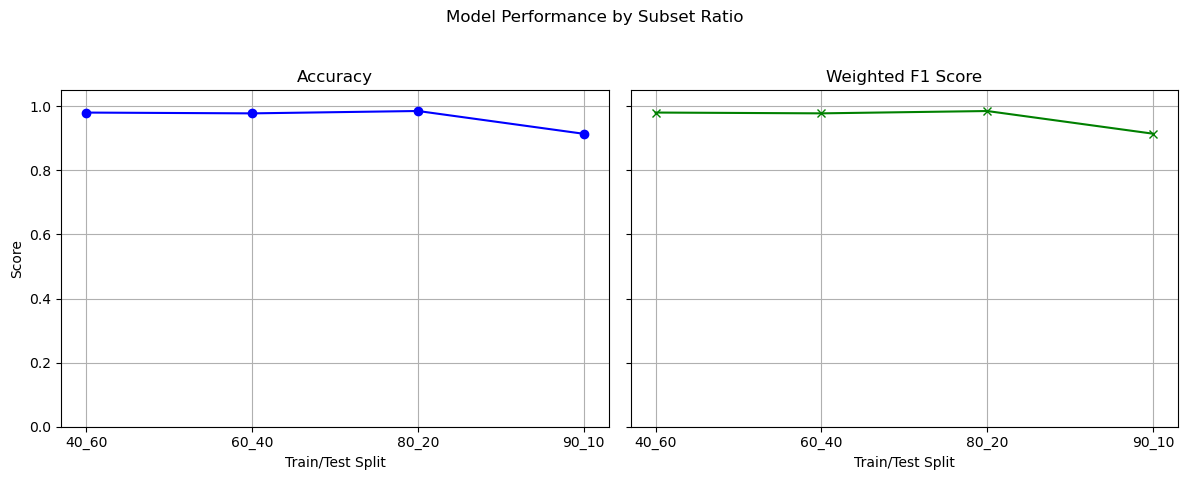

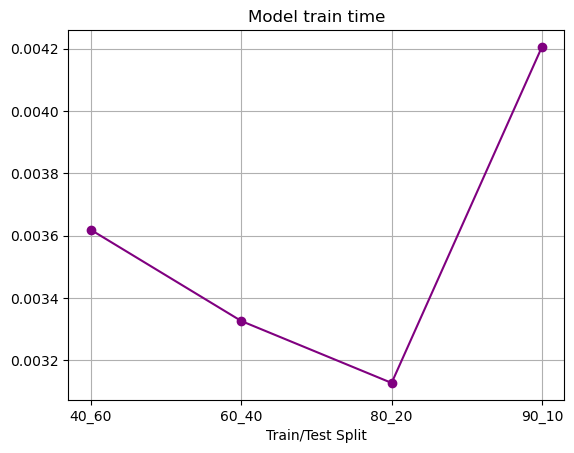

In [5]:
# Set up subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Accuracy plot
axes[0].plot(labels, accuracy_scores, marker="o", color="blue")
axes[0].set_title("Accuracy")
axes[0].set_xlabel("Train/Test Split")
axes[0].set_ylabel("Score")
axes[0].grid(True)
axes[0].set_ylim(0, 1.05)

# Weighted F1 Score plot
axes[1].plot(labels, weighted_f1_scores, marker="x", color="green")
axes[1].set_title("Weighted F1 Score")
axes[1].set_xlabel("Train/Test Split")
axes[1].grid(True)


plt.suptitle("Model Performance by Subset Ratio")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout for title
plt.show()

plt.plot(labels, train_times, marker="o", color="purple")
plt.title("Model train time")
plt.xlabel("Train/Test Split")
plt.grid(True)
plt.show()


Model performance remains consistently high across most train/test splits; however, a noticeable decline in accuracy is observed at the 90/10 ratio. This degradation is likely attributable to overfitting, as the model, trained on an overwhelmingly large portion of the data, may have learned patterns too specific to the training set. Consequently, its ability to generalize to the comparatively small and potentially non-representative test set diminishes. The inconsistency in class distributions between the training and test sets at this ratio may further exacerbate this issue.

In [6]:
# Models performances are very high at most subset ratios, but took a drop at 90/10
# Overfitting is a likely cause, as the class distribtions between the trainning set and testing set are less consistent than the other ratios.


decision tree (80/20, max depth: None)
train time: 1.9073486328125e-05s


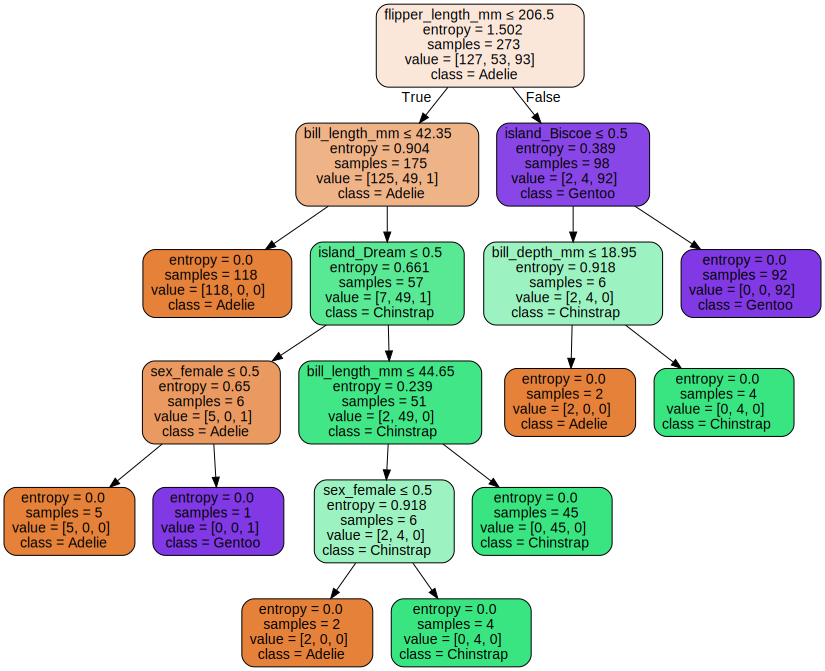


decision tree (80/20, max depth: 2)
train time: 2.8371810913085938e-05s


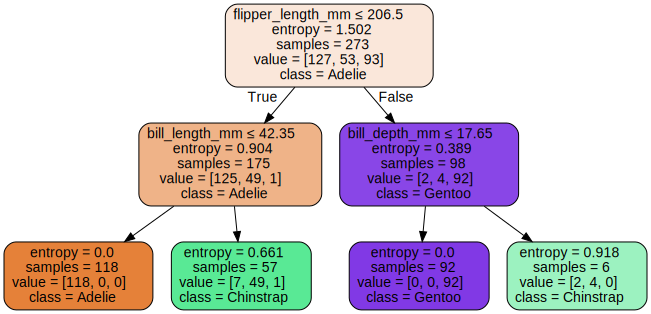


decision tree (80/20, max depth: 3)
train time: 2.6226043701171875e-05s


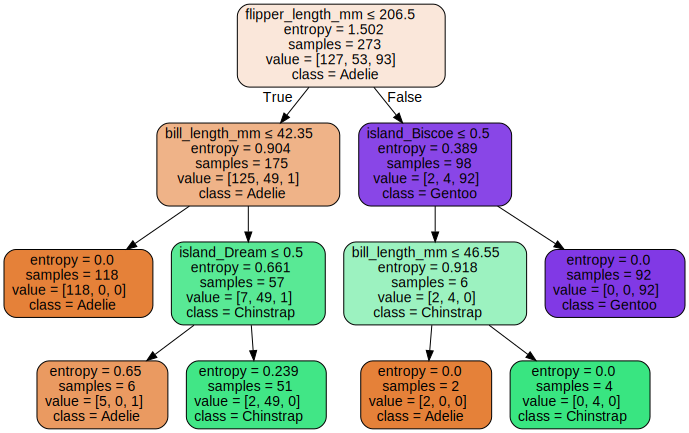


decision tree (80/20, max depth: 4)
train time: 2.2411346435546875e-05s


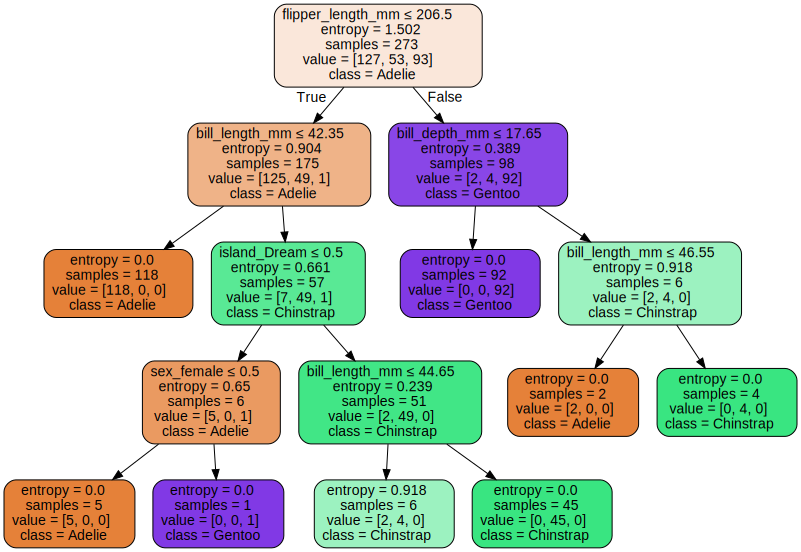


decision tree (80/20, max depth: 5)
train time: 2.288818359375e-05s


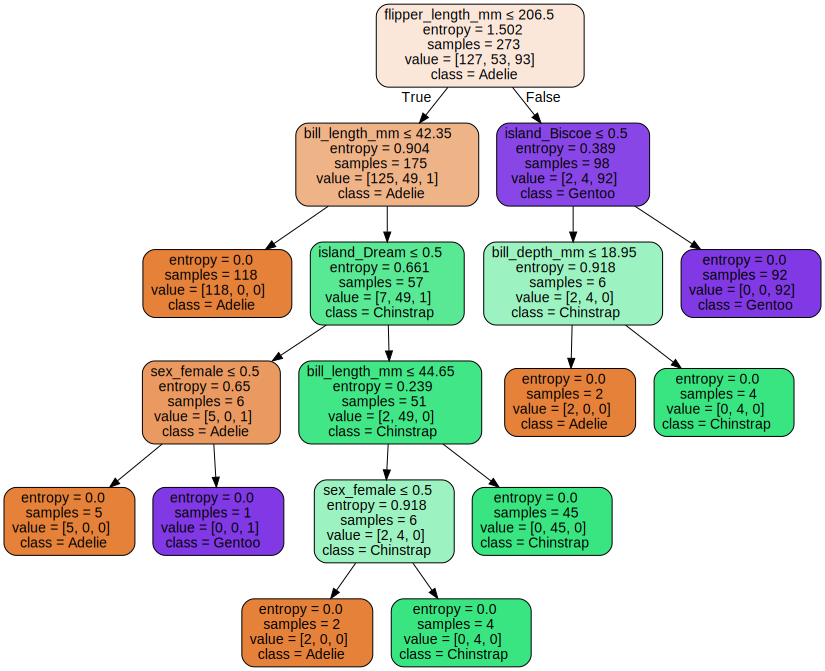


decision tree (80/20, max depth: 6)
train time: 2.3603439331054688e-05s


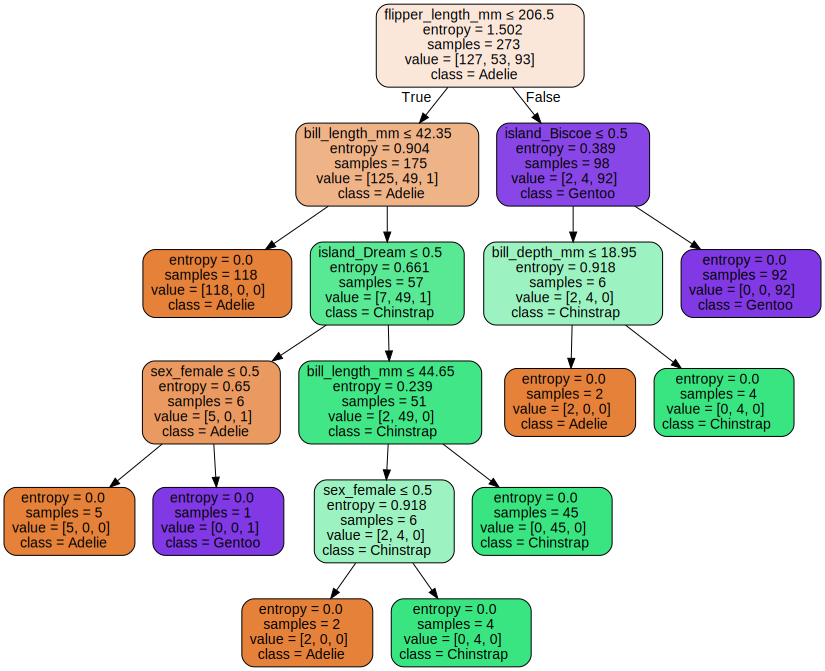


decision tree (80/20, max depth: 7)
train time: 2.2649765014648438e-05s


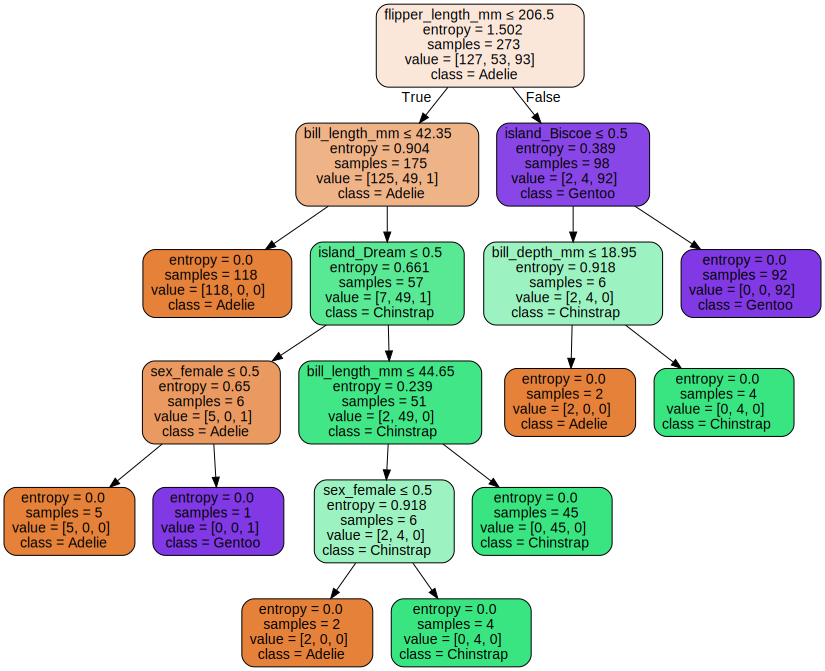


Accuracy theo max_depth:
   max_depth  Train Accuracy  Test Accuracy  train_time
0        inf        1.000000       0.985507    0.000019
1        2.0        0.963370       0.927536    0.000028
2        3.0        0.989011       0.985507    0.000026
3        4.0        0.992674       0.985507    0.000022
4        5.0        1.000000       0.985507    0.000023
5        6.0        1.000000       0.985507    0.000024
6        7.0        1.000000       0.985507    0.000023


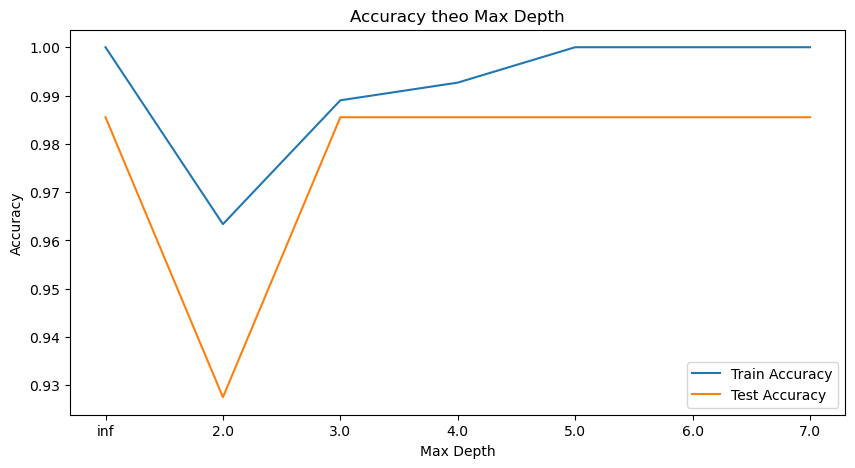

max accuracy: 0.9855072463768116
Optimal max_depth = {'max_depth': 3, 'Train Accuracy': 0.989010989010989, 'Test Accuracy': 0.9855072463768116, 'train_time': 2.6226043701171875e-05}


In [7]:

#2.4
max_depths = [None, 2, 3, 4, 5, 6, 7]
results = []

feature_train = pd.read_csv(f'penguin_prepared_subsets/feature_train_80_20.csv')
feature_test = pd.read_csv(f'penguin_prepared_subsets/feature_test_80_20.csv')
label_train = pd.read_csv(f'penguin_prepared_subsets/label_train_80_20.csv')
label_test = pd.read_csv(f'penguin_prepared_subsets/label_test_80_20.csv')

for depth in max_depths:

    start_time = time.time()
    dt = DecisionTreeClassifier(
        criterion="entropy", 
        max_depth=depth, 
        random_state=273
    )
    train_time = time.time() - start_time

    dt.fit(feature_train, label_train)
    
    train_acc = dt.score(feature_train, label_train)
    test_acc = dt.score(feature_test, label_test)
    results.append({
        'max_depth': depth if depth is not None else float('inf'),
        'Train Accuracy': train_acc,
        'Test Accuracy': test_acc,
        'train_time': train_time
    })

    # visualise the tree of each depth
    tree = visualize_tree(dt, feature_cols, dt.classes_, f'id3_tree/penguin_decision_tree_max_depth_{depth}')
    print('')
    print(f'decision tree (80/20, max depth: {depth})')
    print(f'train time: {train_time}s')
    display(tree)

# Hiển thị kết quả
results_df = pd.DataFrame(results)
print("\nAccuracy theo max_depth:")
print(results_df)

# Visualize kết quả
plt.figure(figsize=(10, 5))
plt.plot(
    results_df['max_depth'].astype(str), 
    results_df['Train Accuracy'], 
    label='Train Accuracy'
)
plt.plot(
    results_df['max_depth'].astype(str), 
    results_df['Test Accuracy'], 
    label='Test Accuracy'
)
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Accuracy theo Max Depth')
plt.legend()
plt.show()



delta = 0.005 # configure if needed, 
# the goal: find the shallowest max depth that give the most accuracy difference
# delta is how much accuracy we are willing to give up for more performance,in other word how much accuracy lost is tolerated
max_test_acc = max(r["Test Accuracy"] for r in results)
print(f'max accuracy: {max_test_acc}')
candidates = [r for r in results if (max_test_acc - r["Test Accuracy"]) <= delta]

#remove none candidate


optimal_depth = min(candidates, key=lambda r: r["max_depth"])

print(f'Optimal max_depth = {optimal_depth}')

# best_row = results_df.loc[results_df['Test Accuracy'].idxmax()]
# best_depth = None if best_row['max_depth']=='None' else int(best_row['max_depth'])
# print(f"Optimal max_depth = {optimal_depth!r}, Test Accuracy = {best_row['Test Accuracy']:.4f}")

# # Train lại model với độ sâu tối ưu
# dt_opt = DecisionTreeClassifier(criterion="entropy",
#                                 max_depth=best_depth,
#                                 random_state=273)

The maximum effective depth for the decision tree on this dataset is 5. Beyond this point (i.e., at depths of 6, 7, or with max_depth=None), the tree structure remains unchanged, as all possible splits have already been exhausted.

Training accuracy increases monotonically with depth, reaching a perfect score of 1.0 as the tree fully memorizes the training data. However, test accuracy plateaus at a depth of 3, with no observable improvement beyond this point. This indicates that a depth of 3 strikes the optimal balance between model complexity and generalization performance.

Thus, setting max_depth=3 is recommended to minimize overfitting while preserving predictive accuracy.

In [8]:
# The max depth possible for this dataset is 5, so result for None, 5, 6, 7 are the same as they are the same decision tree.
# Train accuracy keep increasing to a perfect 1, yet test accuary's growth halt at max depth of 3. So 3 is the optimal depth for this tree

References: https://chatgpt.com/share/68444681-7dec-800a-9a20-23fdabf46c01